# Next-frame prediction with Conv-LSTM

**Author:** [jeammimi](https://github.com/jeammimi)<br>
**Date created:** 2016/11/02<br>
**Last modified:** 2020/05/01<br>
**Description:** Predict the next frame in a sequence using a Conv-LSTM model.

Not sure this is worth the effort, saving.

## Introduction

This script demonstrates the use of a convolutional LSTM model.
The model is used to predict the next frame of an artificially
generated movie which contains moving squares.


## Setup


In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt


## Build a model

We create a model which take as input movies of shape
`(n_frames, width, height, channels)` and returns a movie
of identical shape.


In [2]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
opt = keras.optimizers.Adadelta(learning_rate=1e-2)
seq.compile(loss="binary_crossentropy", optimizer=opt)
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 40, 40, 40)  1

## Generate artificial data

Generate movies with 3 to 7 moving squares inside.
The squares are of shape 1x1 or 2x2 pixels,
and move linearly over time.
For convenience, we first create movies with bigger width and height (80x80)
and at the end we select a 40x40 window.


In [3]:

def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies



## Train the model


In [4]:
epochs = 100

early_stopping = keras.callbacks.EarlyStopping(patience=10)

noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=10,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/100
90/90 - 37s - loss: 0.6938 - val_loss: 0.7220
Epoch 2/100
90/90 - 29s - loss: 0.5741 - val_loss: 0.7731
Epoch 3/100
90/90 - 29s - loss: 0.5024 - val_loss: 0.7840
Epoch 4/100
90/90 - 29s - loss: 0.4353 - val_loss: 0.6908
Epoch 5/100
90/90 - 29s - loss: 0.3676 - val_loss: 0.6511
Epoch 6/100
90/90 - 29s - loss: 0.3086 - val_loss: 0.6539
Epoch 7/100
90/90 - 29s - loss: 0.2598 - val_loss: 0.5153
Epoch 8/100
90/90 - 29s - loss: 0.2198 - val_loss: 0.3339
Epoch 9/100
90/90 - 29s - loss: 0.1869 - val_loss: 0.2748
Epoch 10/100
90/90 - 29s - loss: 0.1599 - val_loss: 0.1926
Epoch 11/100
90/90 - 29s - loss: 0.1371 - val_loss: 0.1719
Epoch 12/100
90/90 - 29s - loss: 0.1187 - val_loss: 0.1219
Epoch 13/100
90/90 - 29s - loss: 0.1037 - val_loss: 0.1081
Epoch 14/100
90/90 - 29s - loss: 0.0908 - val_loss: 0.1044
Epoch 15/100
90/90 - 29s - loss: 0.0801 - val_loss: 0.0849
Epoch 16/100
90/90 - 29s - loss: 0.0712 - val_loss: 0.0706
Epoch 17/100
90/90 - 29s - loss: 0.0634 - val_loss: 0.0626
Epoch 

## Test the model on one movie

Feed it with the first 7 positions and then
predict the new positions.


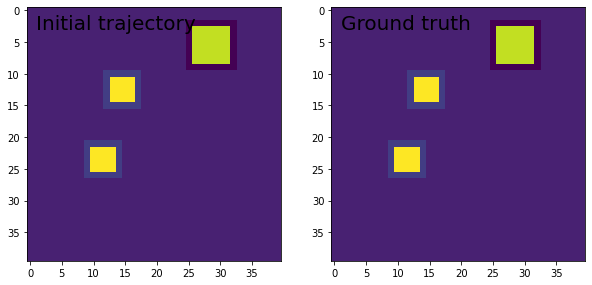

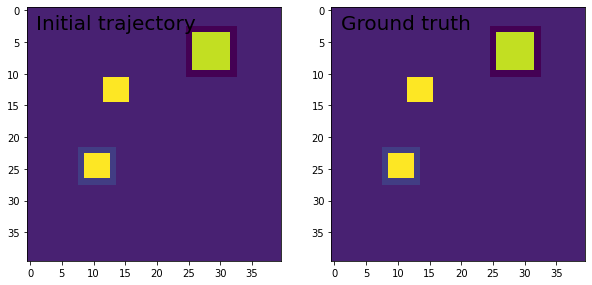

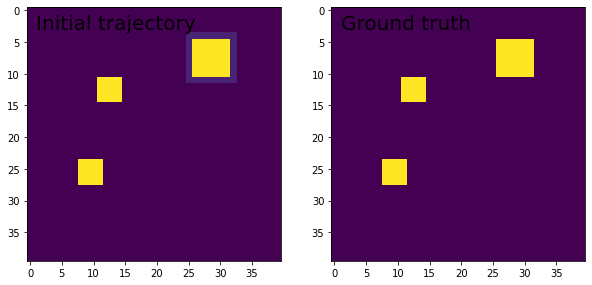

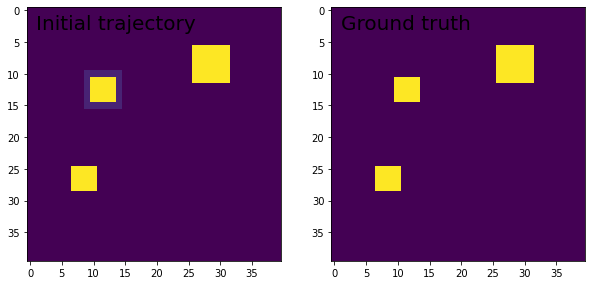

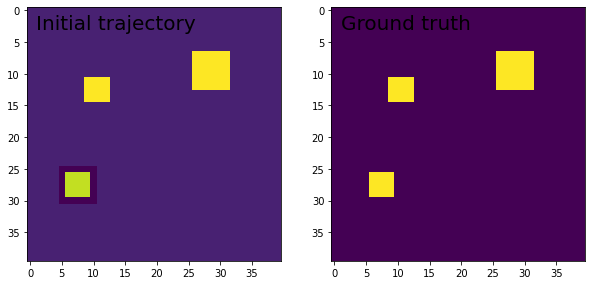

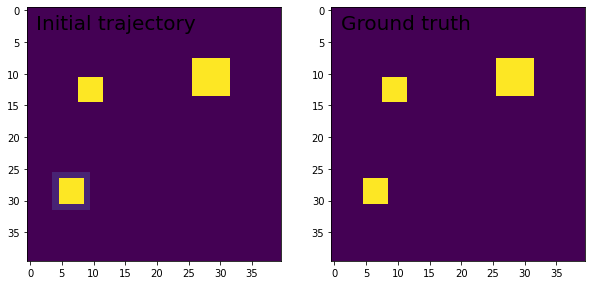

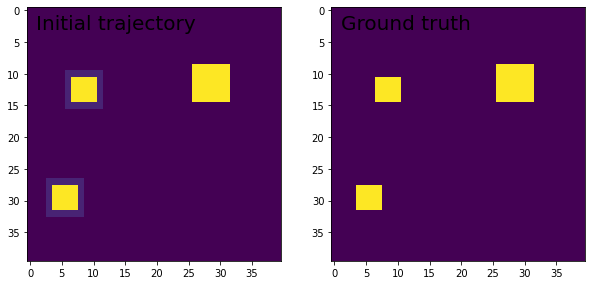

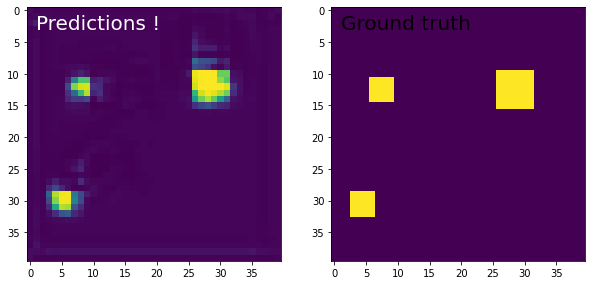

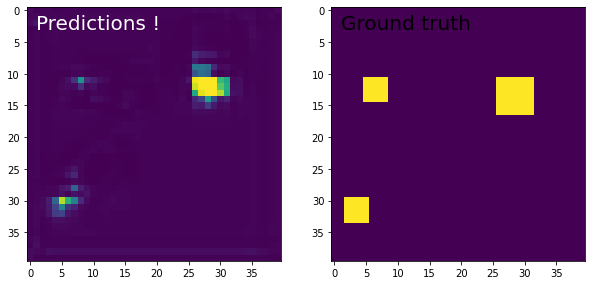

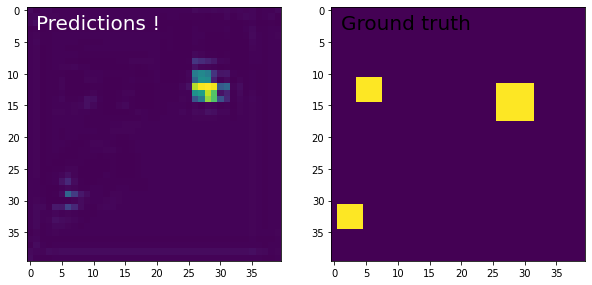

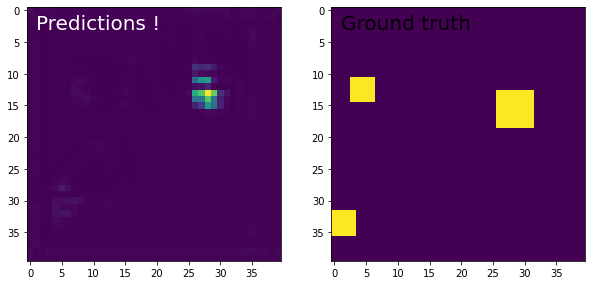

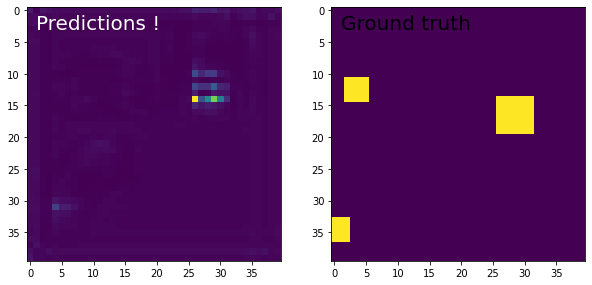

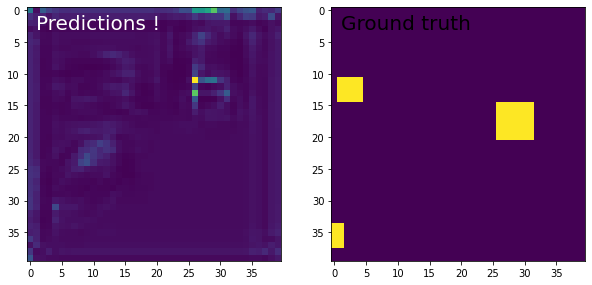

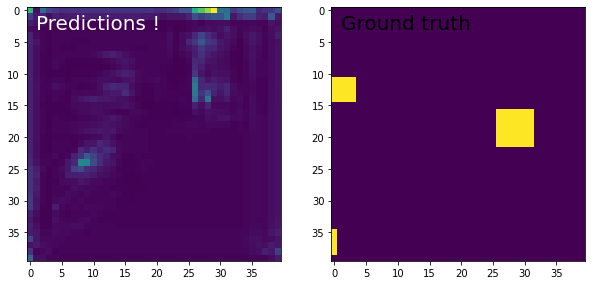

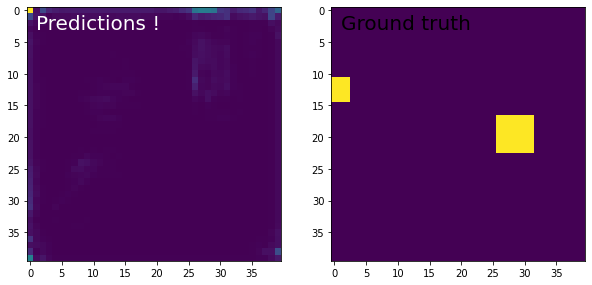

In [5]:
movie_index = 1004
track = noisy_movies[movie_index][:7, ::, ::, ::]

for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)


# And then compare the predictions
# to the ground truth
track2 = noisy_movies[movie_index][::, ::, ::, ::]
for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, "Predictions !", fontsize=20, color="w")
    else:
        ax.text(1, 3, "Initial trajectory", fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, "Ground truth", fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = shifted_movies[movie_index][i - 1, ::, ::, 0]

    plt.imshow(toplot)
    plt.savefig("%i_animate.png" % (i + 1))


# WedgeDropoutLSTM2D

In [6]:
!pip uninstall -y keras-wedge-dropout
!pip install -q git+https://github.com/LanceNorskog/keras-wedge.git
from keras_wedge_dropout import WedgeDropoutLSTM2D

Found existing installation: keras-wedge-dropout 0.1.0
Uninstalling keras-wedge-dropout-0.1.0:
  Successfully uninstalled keras-wedge-dropout-0.1.0


In [ ]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        WedgeDropoutLSTM2D(0.65, batchwise=True),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
opt = keras.optimizers.Adadelta(learning_rate=5e-4)
seq.compile(loss="binary_crossentropy", optimizer=opt)
seq.summary()

In [9]:
epochs = 200

early_stopping = keras.callbacks.EarlyStopping(patience=10)

noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=10,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
    callbacks=[early_stopping]
)


Epoch 1/200
90/90 - 30s - loss: 0.6095 - val_loss: 0.5778
Epoch 2/200
90/90 - 30s - loss: 0.6032 - val_loss: 0.5765
Epoch 3/200
90/90 - 30s - loss: 0.5946 - val_loss: 0.5685
Epoch 4/200
90/90 - 30s - loss: 0.5886 - val_loss: 0.5612
Epoch 5/200
90/90 - 30s - loss: 0.5819 - val_loss: 0.5499
Epoch 6/200
90/90 - 30s - loss: 0.5754 - val_loss: 0.5479
Epoch 7/200
90/90 - 30s - loss: 0.5673 - val_loss: 0.5383
Epoch 8/200
90/90 - 30s - loss: 0.5609 - val_loss: 0.5367
Epoch 9/200
90/90 - 30s - loss: 0.5566 - val_loss: 0.5246
Epoch 10/200
90/90 - 30s - loss: 0.5501 - val_loss: 0.5167
Epoch 11/200
90/90 - 30s - loss: 0.5428 - val_loss: 0.5138
Epoch 12/200
90/90 - 30s - loss: 0.5359 - val_loss: 0.5060
Epoch 13/200
90/90 - 30s - loss: 0.5319 - val_loss: 0.5022
Epoch 14/200
90/90 - 30s - loss: 0.5271 - val_loss: 0.4950
Epoch 15/200
90/90 - 30s - loss: 0.5205 - val_loss: 0.4906
Epoch 16/200
90/90 - 30s - loss: 0.5110 - val_loss: 0.4850
Epoch 17/200
90/90 - 30s - loss: 0.5128 - val_loss: 0.4888
Epoch 